In [1]:
import pandas as pd
import joblib
import os
import numpy as np
import random
random.seed(5)
np.random.seed(5)

# Визуализация
import matplotlib.pyplot as plt

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

# Метрики
from sklearn.metrics import (r2_score,
                             mean_squared_error as MSE,
                             mean_absolute_error as MAE)

# Создание пайплайна
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Масштабирование и кодирование признаков
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   PolynomialFeatures)

# Подбор гиперпараметров
from sklearn.model_selection import GridSearchCV

DATA_PATH = '../data'
MODEL_PATH = '../models/'

## Загрузка и подготовка данных

In [2]:
# Загрузим датасет.
# Зададим типы данных в колонках.
dtypes_of_data = {
            'car_make':'category',
            'car_model':'category',
            'car_gen':'category',
            'car_type':'category',
            'car_compl':'object',
            #'ann_date':datetime64[ns],
            'car_price':float,
            'ann_city':'category',
            'avail':'category',
            'year':int,
            'mileage':float,
            'color':'category',
            'eng_size':float,
            'eng_power':int,
            'eng_type':'category',
            'pow_resrv':int,
            'options':'object',
            'transmission':'category',
            'drive':'category',
            'st_wheel':'category',
            'count_owner':int,
            'original_pts':'category',
            'state_mark':'category',
            'class_auto':'category',
            'door_count':int,
            'long':int,
            'width':int,
            'height':int,
            'clearence':int,
            'v_tank':int,
            'curb_weight':int,
            'front_brakes':'category',
            'rear_brakes':'category',
            'max_speed':int,
            'acceleration':float,
            'fuel_cons':float,
            'fuel_brand':'category',
            'engine_loc1':'category',
            'engine_loc2':'category',
            'turbocharg':'category',
            'max_torq':int,
            'cyl_count':int,
            'seat_count':int,
            'v_bag':int,
            'acc_capacity':int,
            'age':int,
            'age_mod':float,
            'mileage_mod': float,
            'acceleration_mod': float,
            'cyl_count_mod': float            
        }
try:
    train = pd.read_csv(os.path.join(DATA_PATH, 'processed_train.csv'),
                   dtype=dtypes_of_data, parse_dates=['ann_date'])
    test = pd.read_csv(os.path.join(DATA_PATH, 'processed_test.csv'),
               dtype=dtypes_of_data, parse_dates=['ann_date'])
except:
    print('Changed directory for model to current directory')
    train = pd.read_csv('processed_train.csv',
                   dtype=dtypes_of_data, parse_dates=['ann_date'])
    test = pd.read_csv('processed_test.csv',
               dtype=dtypes_of_data, parse_dates=['ann_date'])
print(f'train {train.shape}, test {test.shape}')

train (122898, 50), test (40966, 50)


In [3]:
# Уменьшим избыточную разрядность чисел
fcols = train.select_dtypes('floating').columns
icols = train.select_dtypes('integer').columns
train[fcols] = train[fcols].apply(pd.to_numeric, downcast='float')
train[icols] = train[icols].apply(pd.to_numeric, downcast='integer')
test[fcols] = test[fcols].apply(pd.to_numeric, downcast='float')
test[icols] = test[icols].apply(pd.to_numeric, downcast='integer')

In [4]:
# Рассмотрим общие сведения
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122898 entries, 0 to 122897
Data columns (total 50 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   car_make          122898 non-null  category      
 1   car_model         122898 non-null  category      
 2   car_gen           122898 non-null  category      
 3   car_type          122898 non-null  category      
 4   car_compl         122898 non-null  object        
 5   car_price         122898 non-null  float32       
 6   ann_city          122898 non-null  category      
 7   avail             122898 non-null  category      
 8   year              122898 non-null  int16         
 9   mileage           122898 non-null  float32       
 10  color             122898 non-null  category      
 11  eng_size          122898 non-null  float32       
 12  eng_power         122898 non-null  int16         
 13  eng_type          122898 non-null  category      
 14  pow_

In [5]:
# Рассмотрим общие сведения
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40966 entries, 0 to 40965
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   car_make          40966 non-null  category      
 1   car_model         40966 non-null  category      
 2   car_gen           40966 non-null  category      
 3   car_type          40966 non-null  category      
 4   car_compl         40966 non-null  object        
 5   car_price         40966 non-null  float32       
 6   ann_city          40966 non-null  category      
 7   avail             40966 non-null  category      
 8   year              40966 non-null  int16         
 9   mileage           40966 non-null  float32       
 10  color             40966 non-null  category      
 11  eng_size          40966 non-null  float32       
 12  eng_power         40966 non-null  int16         
 13  eng_type          40966 non-null  category      
 14  pow_resrv         4096

## Метрики качества

Для информации о качестве моделей будем рассчитывать R2, MSE, MAE.

Возьмём в качестве дополнительной метрики долю верно спрогнозированных цен, при этом ошибка недопрогноза и перепрогноза будет учитываться по-разному:
- по недопрогнозов учитываем те прогнозы, которые в пределах отклонения under_est,
- по перепрогнозам - те прогнозы, которые в пределах отклонения over_est.  
Т.е. среди всех предсказанных цен на авто посчитаем долю прогнозов, отличающихся от реальных цен на эти авто не более чем на `under_est`% в сторону уменьшения и не более чем на `over_est`% в сторону увеличения.

In [6]:
def good_prediction_part(y_true, y_pred, under_est=0.05, over_est=0.10):
    deviations = abs(y_pred - y_true) / y_true

    result = (((deviations - 1 <= over_est) & (deviations > 1)).sum() +
              ((1 - deviations >= under_est) & (deviations < 1)).sum()) / len(y_true)

    return result

In [7]:
def print_metrics(model, y_train, y_test, X_train, X_test):
    print('Обучающая выборка')
    print(f'{"R2": <40} {r2_score(y_train, model.predict(X_train)): .5}')
    print(f'{"MSE": <40} {MSE(y_train, model.predict(X_train)): .5}')
    print(f'{"MAE": <40} {MAE(y_train, model.predict(X_train)): .5}')
    print(f'{"Доля предсказаний 0,95-1,1 от цены": <40} {good_prediction_part(y_train, model.predict(X_train)): .5}')
    print('Тестовая выборка')
    print(f'{"R2": <40} {r2_score(y_test, model.predict(X_test)): .5}')
    print(f'{"MSE": <40} {MSE(y_test, model.predict(X_test)): .5}')
    print(f'{"MAE": <40} {MAE(y_test, model.predict(X_test)): .5}')
    print(f'{"Доля предсказаний 0,95-1,1 от цены": <40} {good_prediction_part(y_test, model.predict(X_test)): .5}')

## Модели на числовых признаках

In [8]:
# Список признаков
X = ['car_make', 'car_model', 'car_gen', 'car_type', 'car_compl',
       'ann_city', 'avail', 'year', 'mileage', 'color',
       'eng_size', 'eng_power', 'eng_type', 'pow_resrv', 'options',
       'transmission', 'drive', 'st_wheel', 'count_owner', 'original_pts',
       'state_mark', 'class_auto', 'door_count', 'long', 'width', 'height',
       'v_tank', 'curb_weight', 'front_brakes', 'rear_brakes', 'max_speed',
       'acceleration', 'fuel_cons', 'fuel_brand', 'engine_loc1', 'engine_loc2',
       'turbocharg', 'max_torq', 'cyl_count', 'seat_count', 'clearence',
       'v_bag', 'acc_capacity', 'age', 'age_mod', 'mileage_mod',
       'acceleration_mod', 'cyl_count_mod']

# Целевая переменная
y = 'car_price'

In [9]:
# Составим список числовых признаков
num_features = (
    train[X].select_dtypes(
    exclude=['object', 'category']
    ).columns.to_list()
)
num_features

['year',
 'mileage',
 'eng_size',
 'eng_power',
 'pow_resrv',
 'count_owner',
 'door_count',
 'long',
 'width',
 'height',
 'v_tank',
 'curb_weight',
 'max_speed',
 'acceleration',
 'fuel_cons',
 'max_torq',
 'cyl_count',
 'seat_count',
 'clearence',
 'v_bag',
 'acc_capacity',
 'age',
 'age_mod',
 'mileage_mod',
 'acceleration_mod',
 'cyl_count_mod']

In [10]:
# Составим список категориальных признаков
cat_features = train[X].select_dtypes(include=['category']).columns.to_list()
cat_features

['car_make',
 'car_model',
 'car_gen',
 'car_type',
 'ann_city',
 'avail',
 'color',
 'eng_type',
 'transmission',
 'drive',
 'st_wheel',
 'original_pts',
 'state_mark',
 'class_auto',
 'front_brakes',
 'rear_brakes',
 'fuel_brand',
 'engine_loc1',
 'engine_loc2',
 'turbocharg']

In [11]:
y_train = train[y].copy()
X_train_num = train[num_features].copy()
y_test = test[y].copy()
X_test_num = test[num_features].copy()

In [12]:
# Проверим размерность
X_train_num.shape, y_train.shape

((122898, 26), (122898,))

In [13]:
# Проверим размерность
X_test_num.shape, y_test.shape

((40966, 26), (40966,))

In [14]:
# Определим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=True
)

### Линейная регрессия

In [15]:
# Пайплайн обработки данных и обучения Линейной регрессии
lr_pl = make_pipeline(col_transformer, LinearRegression())
# Обучим модель
lr_pl.fit(X_train_num, y_train)

# Вычислим метрики
print_metrics(model=lr_pl,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_num,
              X_test=X_test_num)

# Сохраним модель
try:
    _ = joblib.dump(lr_pl,
                    os.path.join(MODEL_PATH, 'lr_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_pl,
                    'lr_pl.pkl',
                    compress=0)

Обучающая выборка
R2                                        0.41713
MSE                                       17.95
MAE                                       1.4264
Доля предсказаний 0,95-1,1 от цены        0.6124
Тестовая выборка
R2                                        0.46549
MSE                                       13.199
MAE                                       1.4049
Доля предсказаний 0,95-1,1 от цены        0.61082


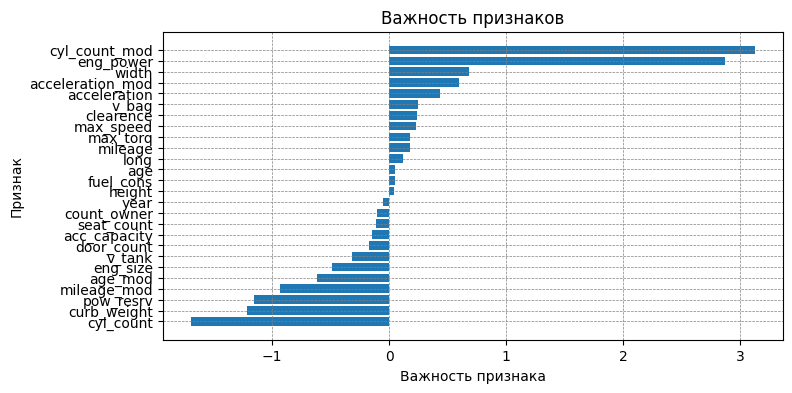

In [16]:
# Проверим важность признаков с точки зрения модели
importances = lr_pl.named_steps['linearregression'].coef_
importances = pd.Series(
    importances,
    index = X_train_num.columns
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Линейная регрессия (Lasso)

In [17]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl = make_pipeline(col_transformer, Lasso())


param_grid_lasso = {
    'lasso__alpha': np.linspace(0.1, 10, 20)
}
gs_lasso_pl = GridSearchCV(
                           lasso_pl,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           pre_dispatch=6,
                           verbose=3,
                           error_score='raise'
)

gs_lasso_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl.best_estimator_,
                    'gs_lasso_pl.pkl',
                    compress=0)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
best_score: 0.4106066823005676
best_params: {'lasso__alpha': np.float64(0.1)}


In [18]:
# Вычислим метрики
print_metrics(model=gs_lasso_pl.best_estimator_,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_num,
              X_test=X_test_num)

Обучающая выборка
R2                                        0.39904
MSE                                       18.507
MAE                                       1.2716
Доля предсказаний 0,95-1,1 от цены        0.67028
Тестовая выборка
R2                                        0.44734
MSE                                       13.647
MAE                                       1.2549
Доля предсказаний 0,95-1,1 от цены        0.67007


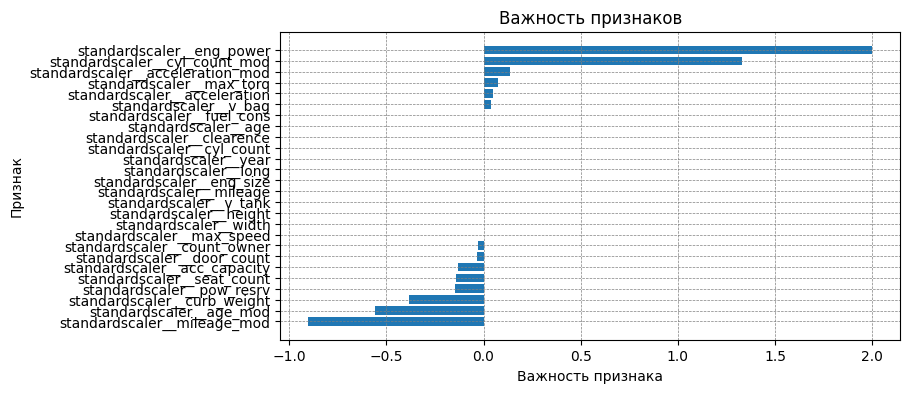

In [19]:
# Проверим важность признаков с точки зрения модели
importances = gs_lasso_pl.best_estimator_['lasso'].coef_
importances = pd.Series(
    importances,
    index=gs_lasso_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
#plt.xlim([0, 20])
#plt.xticks(np.arange(0, 20, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### ElasticNet

In [20]:
# Пайплайн обработки данных и обучения модели ElasticNet
elnet_pl = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet = {
    'elasticnet__alpha': np.linspace(0.1, 10, 20),
    'elasticnet__l1_ratio': np.linspace(0.1, 1, 10),
}
gs_elnet_pl = GridSearchCV(
                           elnet_pl,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_elnet_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl.best_estimator_,
                    'gs_elnet_pl.pkl',
                    compress=0)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
best_score: 0.4148121476173401
best_params: {'elasticnet__alpha': np.float64(0.1), 'elasticnet__l1_ratio': np.float64(0.1)}


In [21]:
# Вычислим метрики
print_metrics(model=gs_elnet_pl.best_estimator_,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_num,
              X_test=X_test_num)

Обучающая выборка
R2                                        0.40276
MSE                                       18.393
MAE                                       1.2976
Доля предсказаний 0,95-1,1 от цены        0.65052
Тестовая выборка
R2                                        0.45031
MSE                                       13.573
MAE                                       1.2816
Доля предсказаний 0,95-1,1 от цены        0.6513


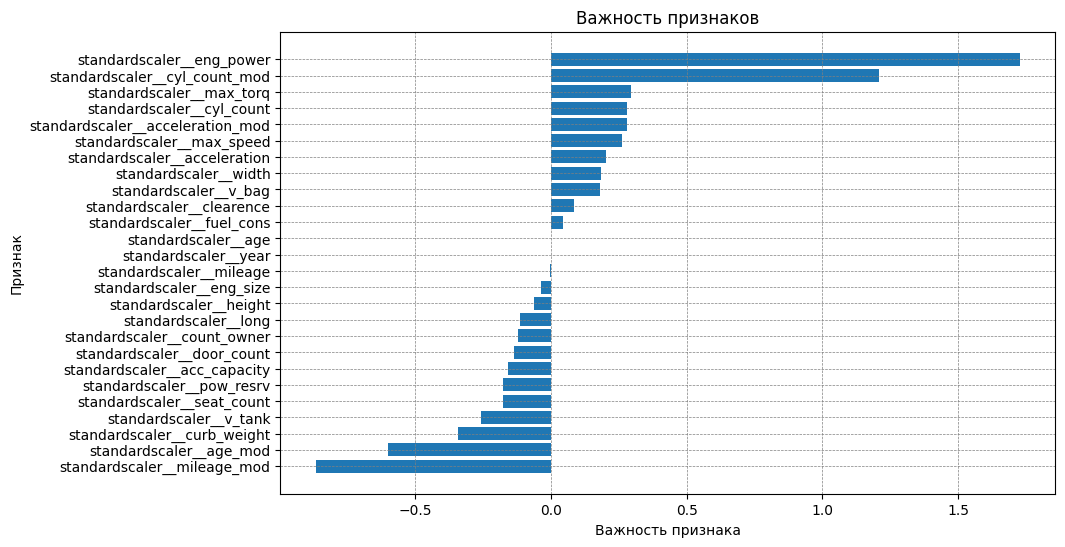

In [22]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Ridge

In [23]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(0.1, 10, 20)
}
gs_ridge_pl = GridSearchCV(
                           ridge_pl,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_ridge_pl.fit(X_train_num, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl.best_estimator_,
                    'gs_ridge_pl.pkl',
                    compress=0)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
best_score: 0.42410334944725037
best_params: {'ridge__alpha': np.float64(10.0)}


In [24]:
# Вычислим метрики
print_metrics(model=gs_ridge_pl.best_estimator_,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_num,
              X_test=X_test_num)

Обучающая выборка
R2                                        0.41718
MSE                                       17.949
MAE                                       1.4259
Доля предсказаний 0,95-1,1 от цены        0.61265
Тестовая выборка
R2                                        0.46551
MSE                                       13.198
MAE                                       1.4043
Доля предсказаний 0,95-1,1 от цены        0.61063


Качество моделей только на числовых признаках невысокое.

## Модели на всех признаках

In [25]:
X_train = train[cat_features + num_features]
X_test = test[cat_features + num_features]

In [26]:
# Обновим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore',
                      drop='first',
                      dtype='int16',
                      sparse_output=True),
        cat_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=True
)

### Линейная регрессия

In [27]:
# Пайплайн обработки данных и обучения Линейной регрессии
lr_pl_ext = make_pipeline(col_transformer, LinearRegression())
# Обучим модель
lr_pl_ext.fit(X_train, y_train)

# Вычислим метрики
print_metrics(model=lr_pl_ext,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train,
              X_test=X_test)

# Сохраним модель
try:
    _ = joblib.dump(lr_pl_ext,
                    os.path.join(MODEL_PATH, 'lr_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_pl_ext,
                    'lr_pl_ext.pkl',
                    compress=0)

Обучающая выборка
R2                                        0.91671
MSE                                       2.565
MAE                                       0.68146
Доля предсказаний 0,95-1,1 от цены        0.8203
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2                                        0.84564
MSE                                       3.8116


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE                                       0.73195
Доля предсказаний 0,95-1,1 от цены        0.80101


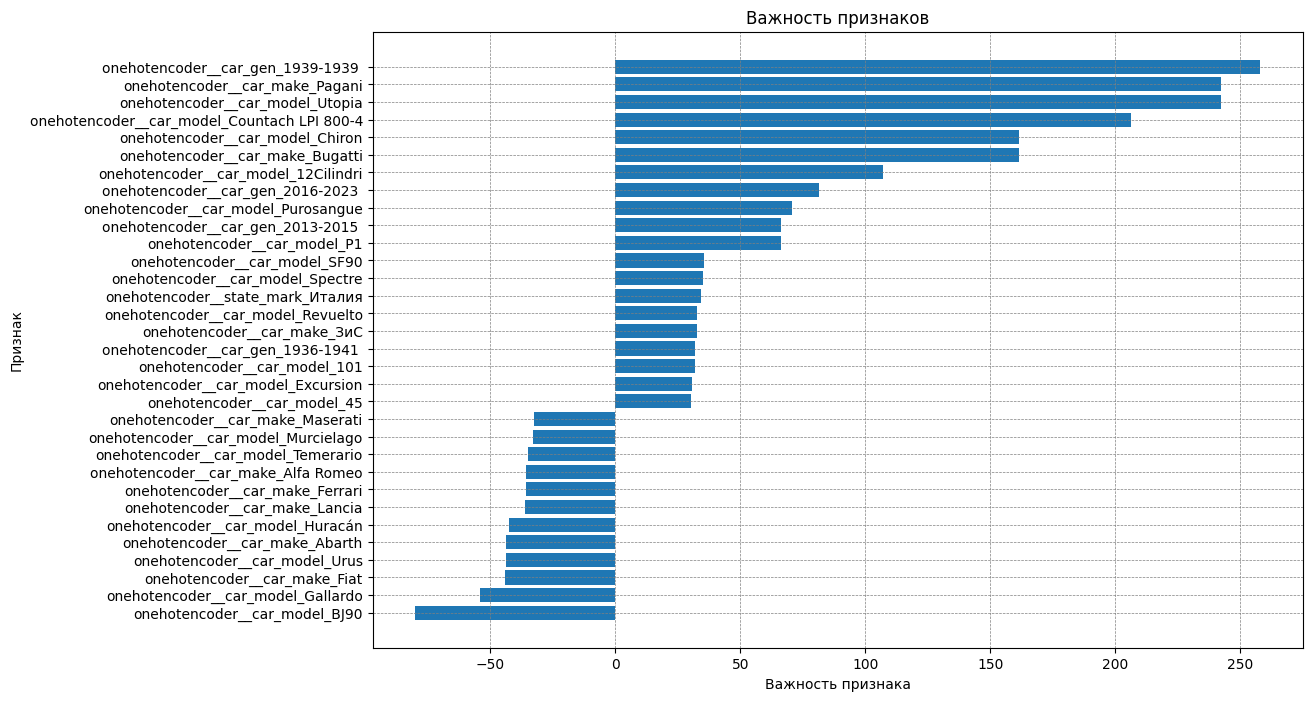

In [28]:
# Проверим важность признаков с точки зрения модели
importances = lr_pl_ext.named_steps['linearregression'].coef_
importances = pd.Series(
    importances,
    index = lr_pl_ext[:-1].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>30]
# Построим диаграмму для наглядности
plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Линейная регрессия (Lasso)

In [29]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl_ext = make_pipeline(col_transformer, Lasso())


param_grid_lasso = {
    'lasso__alpha': np.linspace(0.1, 10, 20)
}
gs_lasso_pl_ext = GridSearchCV(
                           lasso_pl_ext,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_lasso_pl_ext.fit(X_train, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl_ext.best_estimator_,
                    'gs_lasso_pl_ext.pkl',
                    compress=0)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
best_score: 0.4134744554758072
best_params: {'lasso__alpha': np.float64(0.1)}


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1071.87890625, tolerance: 378.48016357421875
  model = cd_fast.sparse_enet_coordinate_descent(


In [30]:
# Вычислим метрики
print_metrics(model=gs_lasso_pl_ext.best_estimator_,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train,
              X_test=X_test)

Обучающая выборка
R2                                        0.40183
MSE                                       18.421
MAE                                       1.2542
Доля предсказаний 0,95-1,1 от цены        0.67244
Тестовая выборка
R2                                        0.45073


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       13.563
MAE                                       1.2377


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Доля предсказаний 0,95-1,1 от цены        0.67156


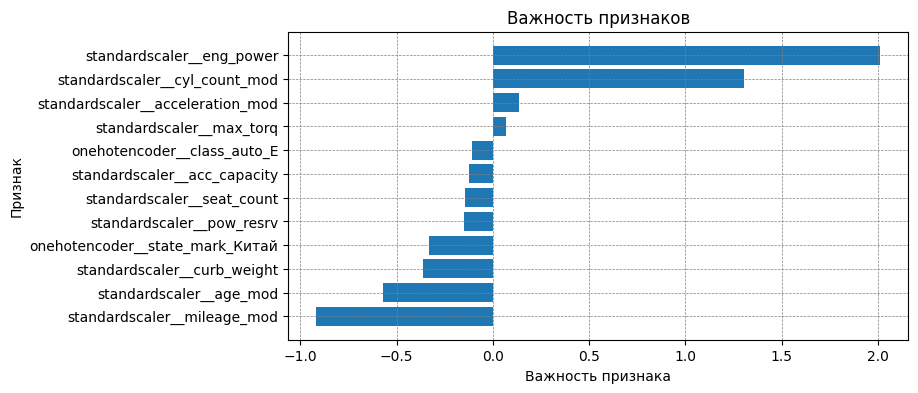

In [31]:
# Проверим важность признаков с точки зрения модели
importances = gs_lasso_pl_ext.best_estimator_['lasso'].coef_
importances = pd.Series(
    importances,
    index=gs_lasso_pl_ext.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.05]
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
#plt.xlim([0, 20])
#plt.xticks(np.arange(0, 20, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### ElasticNet

In [32]:
# Пайплайн обработки данных и обучения модели ElastiNet
elnet_pl_ext = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet = {
    'elasticnet__alpha': np.linspace(0.1, 10, 20),
    'elasticnet__l1_ratio': np.linspace(0.1, 1, 10),
}
gs_elnet_pl_ext = GridSearchCV(
                           elnet_pl_ext,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_elnet_pl_ext.fit(X_train, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl_ext.best_estimator_,
                    'gs_elnet_pl_ext.pkl',
                    compress=0)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
best_score: 0.4380565285682678
best_params: {'elasticnet__alpha': np.float64(0.1), 'elasticnet__l1_ratio': np.float64(0.1)}


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14664.01953125, tolerance: 378.48016357421875
  model = cd_fast.sparse_enet_coordinate_descent(


In [33]:
# Вычислим метрики
print_metrics(model=gs_elnet_pl_ext.best_estimator_,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train,
              X_test=X_test)

Обучающая выборка
R2                                        0.42526
MSE                                       17.7
MAE                                       1.2378
Доля предсказаний 0,95-1,1 от цены        0.66489
Тестовая выборка
R2                                        0.4766


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       12.924
MAE                                       1.2208


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Доля предсказаний 0,95-1,1 от цены        0.66453


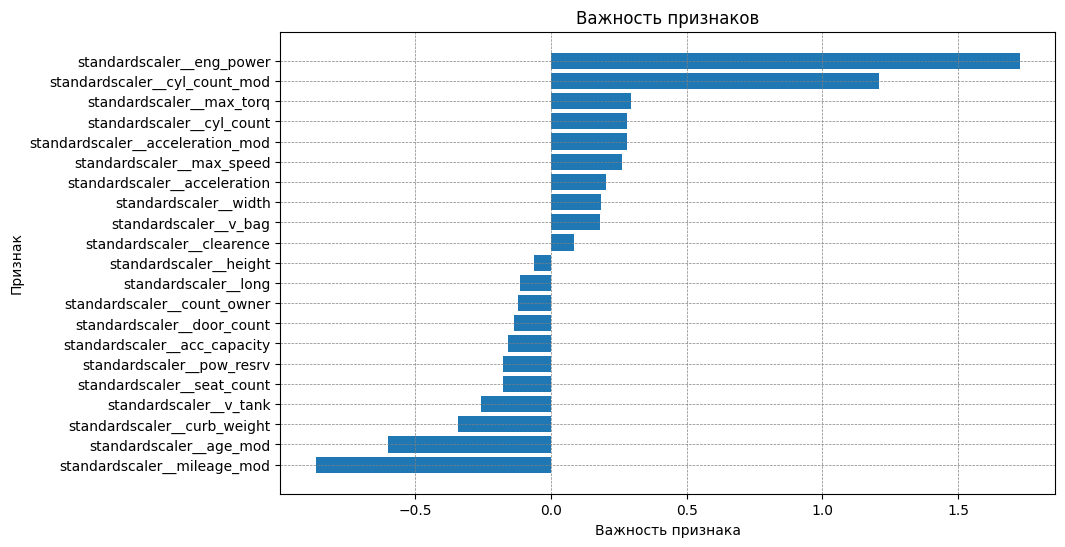

In [34]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.05]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Ridge

In [35]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl_ext = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(0.1, 10, 20)
}
gs_ridge_pl_ext = GridSearchCV(
                           ridge_pl_ext,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise'
)

gs_ridge_pl_ext.fit(X_train, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl_ext.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl_ext.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl_ext.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl_ext.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl_ext.best_estimator_,
                    'gs_ridge_pl_ext.pkl',
                    compress=0)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
best_score: 0.7838857173919678
best_params: {'ridge__alpha': np.float64(0.6210526315789474)}


In [36]:
# Вычислим метрики
print_metrics(model=gs_ridge_pl_ext.best_estimator_,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train,
              X_test=X_test)

Обучающая выборка
R2                                        0.90548
MSE                                       2.911
MAE                                       0.70724
Доля предсказаний 0,95-1,1 от цены        0.81407
Тестовая выборка
R2                                        0.84874


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       3.735


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE                                       0.7405
Доля предсказаний 0,95-1,1 от цены        0.79952


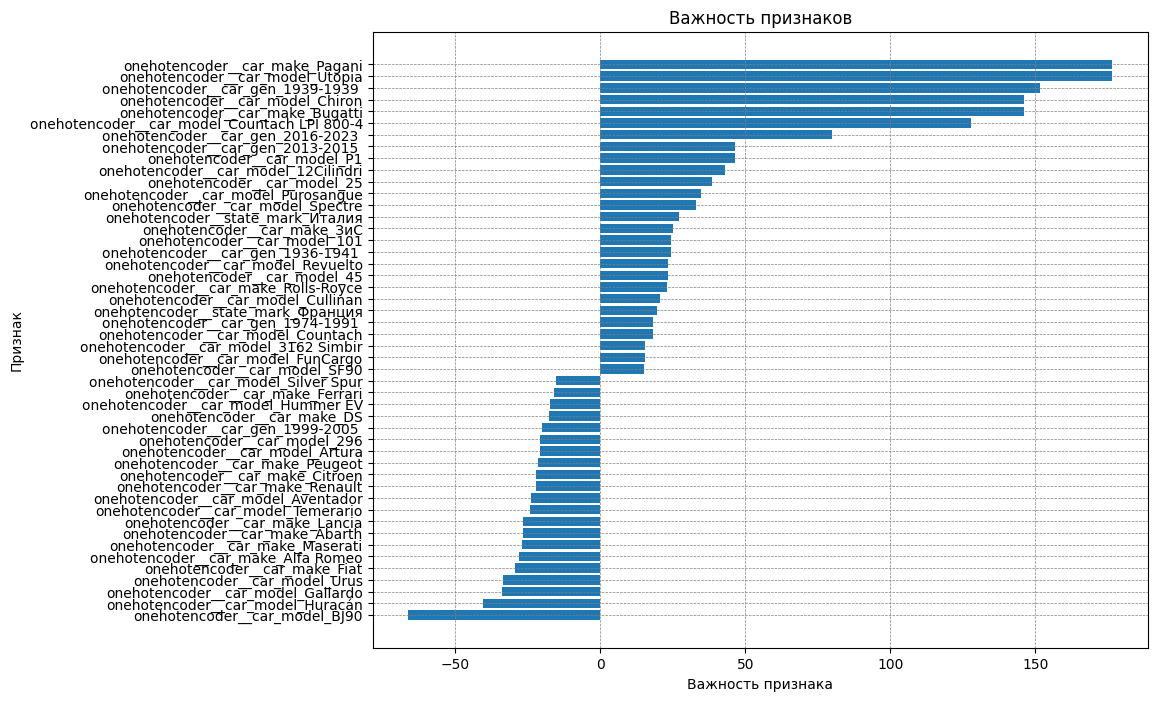

In [37]:
# Проверим важность признаков с точки зрения модели
importances = gs_ridge_pl_ext.best_estimator_['ridge'].coef_
importances = pd.Series(
    importances,
    index=gs_ridge_pl_ext.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>15]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

## Попробуем улучшить модель

Добавим полиномиальные признаки, уменьшим количество категорий категориальных признаков при OHE кодировании.

In [38]:
# Создадим преобразователь признаков
pf = PolynomialFeatures(degree = 2)

# Обучим и преобразуем обучающую выборку
X_poly = pf.fit_transform(X_train[num_features])
X_poly = pd.DataFrame(X_poly,
                      index = X_train.index,
                      columns = pf.get_feature_names_out())
X_train_poly = pd.concat([X_train, X_poly], axis=1).drop(columns=num_features)
X_train_poly.head()

,car_make,car_model,car_gen,car_type,ann_city,avail,color,eng_type,transmission,drive,...,age_mod^2,age_mod mileage_mod,age_mod acceleration_mod,age_mod cyl_count_mod,mileage_mod^2,mileage_mod acceleration_mod,mileage_mod cyl_count_mod,acceleration_mod^2,acceleration_mod cyl_count_mod,cyl_count_mod^2
0,Volkswagen,Tiguan,I,Внедорожник 5 дв.,Видное,В наличии,белый,Бензин,автоматическая,полный,...,3.741657,3.769554,6.086247,1.547469,3.797658,6.131624,1.559006,9.900000,2.517141,0.64
1,Chevrolet,Captiva,I,Внедорожник 5 дв.,Лида,В наличии,золотистый,Дизель,механическая,полный,...,4.123105,4.133709,6.885907,1.624434,4.144341,6.903616,1.628612,11.500000,2.712932,0.64
2,Porsche,Cayenne,I Рестайлинг,Внедорожник 5 дв.,Ставрополь,В наличии,чёрный,Бензин,автоматическая,полный,...,4.123105,3.842984,4.585612,129.954758,3.581894,4.274068,121.125710,5.100000,144.532349,4096.00
3,Chevrolet,Lacetti,I,Хэтчбек 5 дв.,Санкт-Петербург,В наличии,серый,Бензин,механическая,передний,...,4.358899,4.108764,4.835552,1.670238,3.872983,4.558065,1.574392,5.364328,1.852882,0.64
4,Lada (ВАЗ),Granta,I Рестайлинг,Седан,Шелковская,В наличии,белый,Бензин,механическая,передний,...,0.000000,0.000000,0.000000,0.000000,2.059767,5.917435,1.148151,17.000000,3.298485,0.64


In [39]:
# Преобразуем тестовую выборку
X_poly = pf.transform(X_test[num_features])
X_poly = pd.DataFrame(X_poly,
                      index = X_test.index,
                      columns = pf.get_feature_names_out())
X_test_poly = pd.concat([X_test, X_poly], axis=1).drop(columns=num_features)
X_test_poly.head()

,car_make,car_model,car_gen,car_type,ann_city,avail,color,eng_type,transmission,drive,...,age_mod^2,age_mod mileage_mod,age_mod acceleration_mod,age_mod cyl_count_mod,mileage_mod^2,mileage_mod acceleration_mod,mileage_mod cyl_count_mod,acceleration_mod^2,acceleration_mod cyl_count_mod,cyl_count_mod^2
0,Citroen,C3,I,Хэтчбек 5 дв.,Ставрополь,В наличии,серый,Бензин,автоматическая,передний,...,4.472136,3.760603,8.897011,1.691794,3.162278,7.481464,1.422624,17.699999,3.365709,0.64
1,Chevrolet,Aveo,I,Седан,Бахчисарай,В наличии,синий,Бензин,механическая,передний,...,4.358899,4.259205,8.608210,1.670238,4.161791,8.411328,1.632038,17.000000,3.298485,0.64
2,Lada (ВАЗ),2109,1987-2006,Хэтчбек 5 дв.,Канск,В наличии,зелёный,Бензин,механическая,передний,...,5.000000,4.029068,9.219544,1.788854,3.246678,7.429235,1.441483,17.000000,3.298485,0.64
3,SEAT,Cordoba,II Рестайлинг,Седан,Нерюнгри,В наличии,серый,Бензин,механическая,передний,...,4.123105,3.511547,6.548305,1.624434,2.990697,5.577029,1.383491,10.400000,2.579922,0.64
4,Lada (ВАЗ),2111,1997-2014,Универсал 5 дв.,Можайск,В наличии,серебристый,Бензин,механическая,передний,...,4.472136,4.129287,8.719307,1.691794,3.812722,8.050856,1.562096,17.000000,3.298485,0.64


In [40]:
# Уменьшим избыточную разрядность чисел
fcols = X_train_poly.select_dtypes('float').columns
icols = X_train_poly.select_dtypes('integer').columns

X_train_poly[fcols] = X_train_poly[fcols].apply(pd.to_numeric, downcast='float')
X_train_poly[icols] = X_train_poly[icols].apply(pd.to_numeric, downcast='integer')
X_test_poly[fcols] = X_test_poly[fcols].apply(pd.to_numeric, downcast='float')
X_test_poly[icols] = X_test_poly[icols].apply(pd.to_numeric, downcast='integer')

In [41]:
# Обновим список числовых признаков
num_features = (
    X_train_poly.select_dtypes(
    exclude=['object', 'category']
    ).columns.to_list()
)
num_features

['1',
 'year^2',
 'year mileage',
 'year eng_size',
 'year eng_power',
 'year pow_resrv',
 'year count_owner',
 'year door_count',
 'year long',
 'year width',
 'year height',
 'year v_tank',
 'year curb_weight',
 'year max_speed',
 'year acceleration',
 'year fuel_cons',
 'year max_torq',
 'year cyl_count',
 'year seat_count',
 'year clearence',
 'year v_bag',
 'year acc_capacity',
 'year age',
 'year age_mod',
 'year mileage_mod',
 'year acceleration_mod',
 'year cyl_count_mod',
 'mileage^2',
 'mileage eng_size',
 'mileage eng_power',
 'mileage pow_resrv',
 'mileage count_owner',
 'mileage door_count',
 'mileage long',
 'mileage width',
 'mileage height',
 'mileage v_tank',
 'mileage curb_weight',
 'mileage max_speed',
 'mileage acceleration',
 'mileage fuel_cons',
 'mileage max_torq',
 'mileage cyl_count',
 'mileage seat_count',
 'mileage clearence',
 'mileage v_bag',
 'mileage acc_capacity',
 'mileage age',
 'mileage age_mod',
 'mileage mileage_mod',
 'mileage acceleration_mod',
 '

In [42]:
# Обновим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore',
                      drop='first',
                      dtype='int16',
                      min_frequency=5,
                      max_categories=150,
                      sparse_output=True),
        cat_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    
    remainder='passthrough',
    verbose_feature_names_out=True
)

### Линейная регрессия

In [43]:
# Пайплайн обработки данных и обучения Линейной регрессии
lr_pl_poly = make_pipeline(col_transformer, LinearRegression())
# Обучим модель
lr_pl_poly.fit(X_train_poly, y_train)

# Вычислим метрики
print_metrics(model=lr_pl_poly,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_poly,
              X_test=X_test_poly)

# Сохраним модель
try:
    _ = joblib.dump(lr_pl_poly,
                    os.path.join(MODEL_PATH, 'lr_pl_poly.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_pl_poly,
                    'lr_pl_poly.pkl',
                    compress=0)

Обучающая выборка
R2                                        0.77047
MSE                                       7.0686
MAE                                       0.93242
Доля предсказаний 0,95-1,1 от цены        0.73611
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2                                        0.823


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       4.3706


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE                                       0.91316


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Доля предсказаний 0,95-1,1 от цены        0.73339


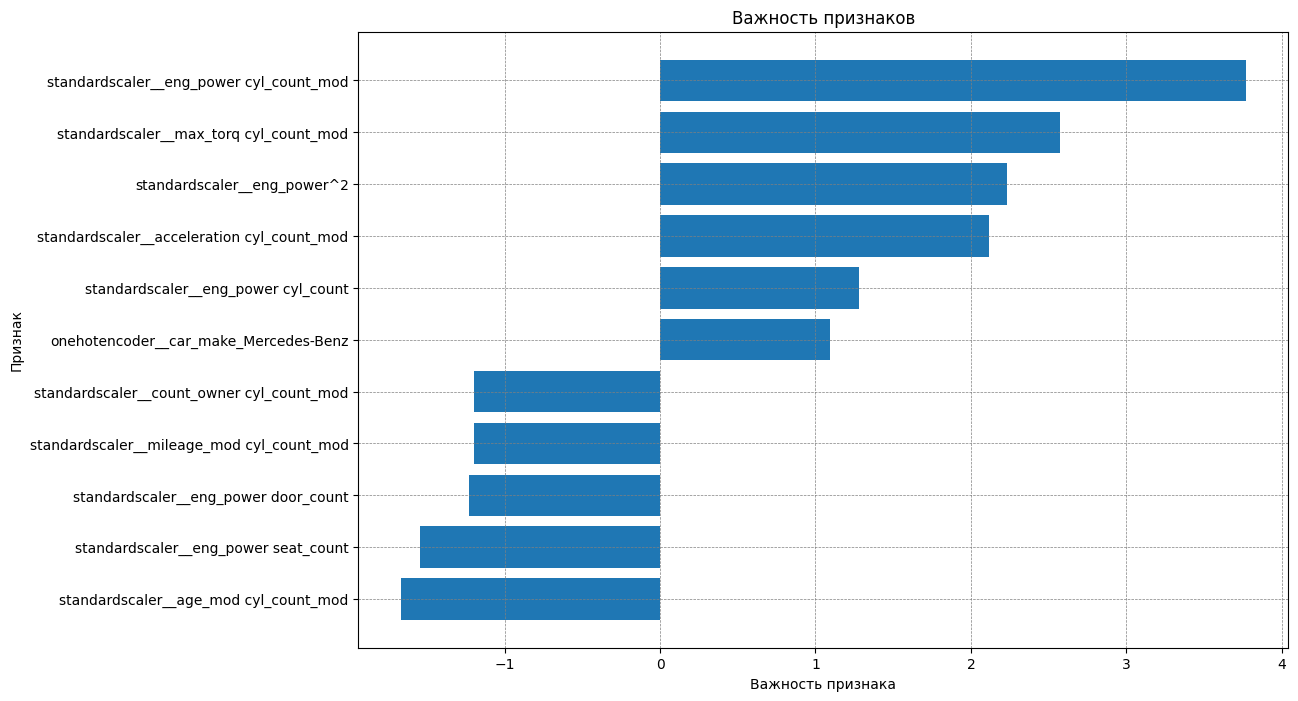

In [44]:
# Проверим важность признаков с точки зрения модели
importances = lr_pl_poly.named_steps['linearregression'].coef_
importances = pd.Series(
    importances,
    index = lr_pl_poly[:-1].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>1]
# Построим диаграмму для наглядности
plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Линейная регрессия (Lasso)

In [45]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl_poly = make_pipeline(col_transformer, Lasso())


param_grid_lasso = {
    'lasso__alpha': np.linspace(0.1, 10, 20)
}
gs_lasso_pl_poly = GridSearchCV(
                           lasso_pl_poly,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=4
)

gs_lasso_pl_poly.fit(X_train_poly, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl_poly.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl_poly.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl_poly.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl_poly.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl_poly.best_estimator_,
                    'gs_lasso_pl_poly.pkl',
                    compress=0)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
best_score: 0.6785060167312622
best_params: {'lasso__alpha': np.float64(0.1)}


In [46]:
# Вычислим метрики
print_metrics(model=gs_lasso_pl_poly.best_estimator_,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_poly,
              X_test=X_test_poly)

Обучающая выборка
R2                                        0.68465
MSE                                       9.7115
MAE                                       0.85007
Доля предсказаний 0,95-1,1 от цены        0.81845
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2                                        0.75535


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       6.0411


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE                                       0.82592


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Доля предсказаний 0,95-1,1 от цены        0.81868


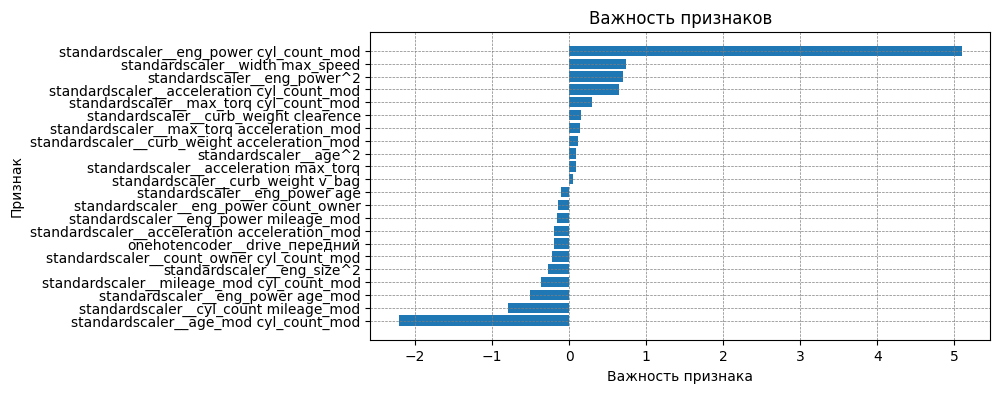

In [47]:
# Проверим важность признаков с точки зрения модели
importances = gs_lasso_pl_poly.best_estimator_['lasso'].coef_
importances = pd.Series(
    importances,
    index=gs_lasso_pl_poly.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.05]
# Построим диаграмму для наглядности
plt.figure(figsize=(8, 4))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
#plt.xlim([0, 20])
#plt.xticks(np.arange(0, 20, step=1), rotation=0)
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### ElasticNet

In [48]:
# Пайплайн обработки данных и обучения модели ElasticNet
elnet_pl_poly = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet = {
    'elasticnet__alpha': np.linspace(0.1, 10, 20),
    'elasticnet__l1_ratio': np.linspace(0.1, 1, 10),
}
gs_elnet_pl_poly = GridSearchCV(
                           elnet_pl_poly,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=4
)

gs_elnet_pl_poly.fit(X_train_poly, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl_poly.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl_poly.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl_poly.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl_poly.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl_poly.best_estimator_,
                    'gs_elnet_pl_poly.pkl',
                    compress=0)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
best_score: 0.7053008824586868
best_params: {'elasticnet__alpha': np.float64(0.1), 'elasticnet__l1_ratio': np.float64(0.1)}


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.137e+04, tolerance: 3.785e+02
  model = cd_fast.enet_coordinate_descent(


In [49]:
# Вычислим метрики
print_metrics(model=gs_elnet_pl_poly.best_estimator_,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_poly,
              X_test=X_test_poly)

Обучающая выборка
R2                                        0.7117
MSE                                       8.8786
MAE                                       0.72798
Доля предсказаний 0,95-1,1 от цены        0.84693
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2                                        0.78505


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       5.3078


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE                                       0.70346


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Доля предсказаний 0,95-1,1 от цены        0.84824


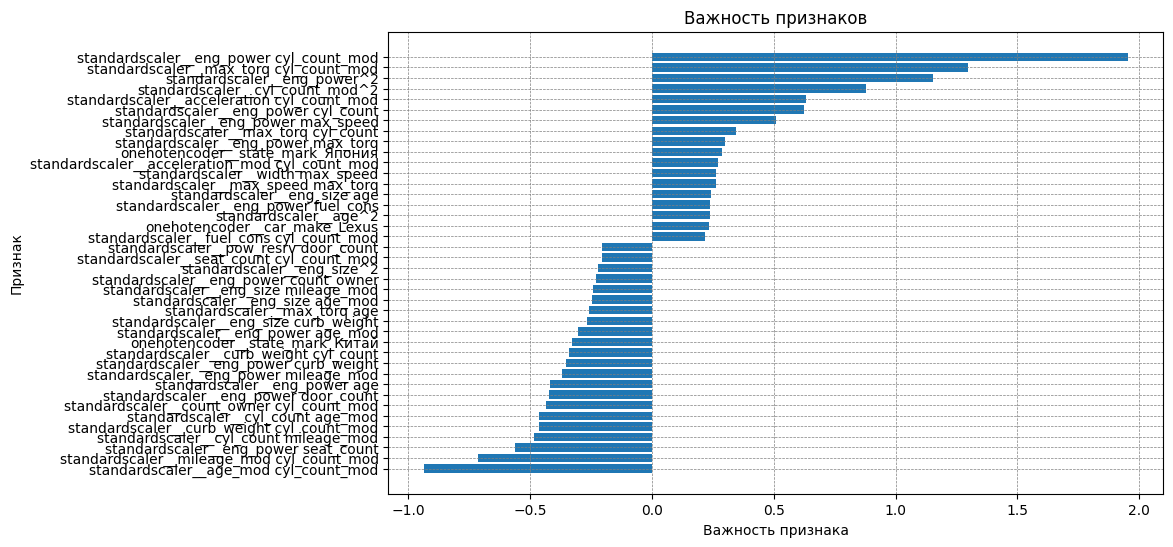

In [50]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl_poly.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl_poly.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.2]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Ridge

In [51]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl_poly = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(0.1, 10, 20)
}
gs_ridge_pl_poly = GridSearchCV(
                           ridge_pl_poly,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=4
)

gs_ridge_pl_poly.fit(X_train_poly, y_train)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl_poly.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl_poly.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl_poly.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl_poly.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl_poly.best_estimator_,
                    'gs_ridge_pl_poly.pkl',
                    compress=0)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
best_score: 0.8285246193408966
best_params: {'ridge__alpha': np.float64(10.0)}


In [52]:
# Вычислим метрики
print_metrics(model=gs_ridge_pl_poly.best_estimator_,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_poly,
              X_test=X_test_poly)

Обучающая выборка
R2                                        0.86194
MSE                                       4.2517
MAE                                       0.64577
Доля предсказаний 0,95-1,1 от цены        0.84464
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2                                        0.8838


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       2.8693


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE                                       0.64329


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Доля предсказаний 0,95-1,1 от цены        0.8406


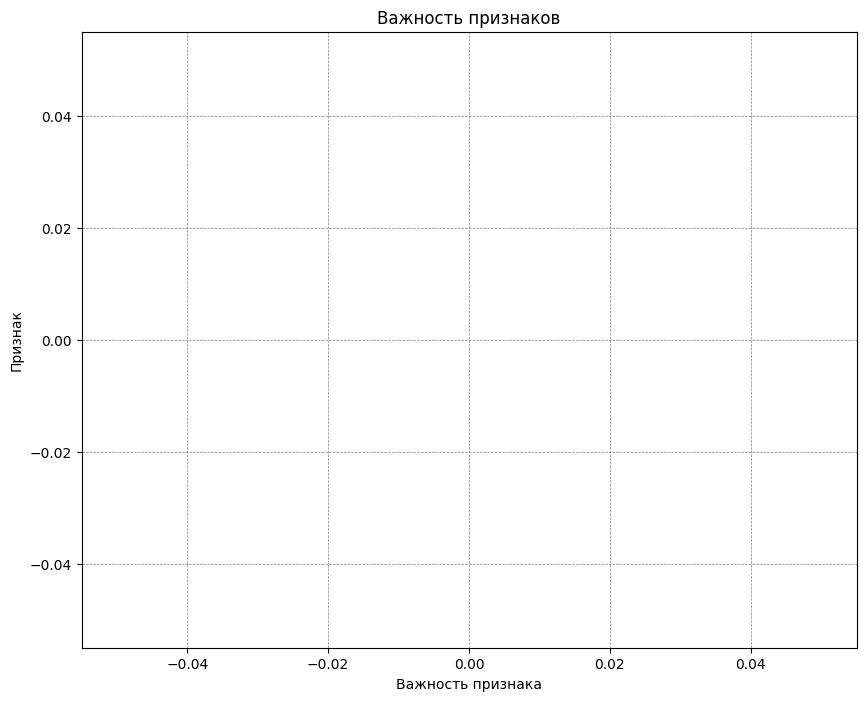

In [53]:
# Проверим важность признаков с точки зрения модели
importances = gs_ridge_pl_poly.best_estimator_['ridge'].coef_
importances = pd.Series(
    importances,
    index=gs_ridge_pl_poly.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>15]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

## Логарифмируем целевую переменную

In [54]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

### Линейная регрессия

In [55]:
# Пайплайн обработки данных и обучения Линейной регрессии
lr_pl_poly_log = make_pipeline(col_transformer, LinearRegression())
# Обучим модель
lr_pl_poly_log.fit(X_train_poly, y_train_log)

# Вычислим метрики
print_metrics(model=lr_pl_poly_log,
              y_train=y_train_log,
              y_test=y_test_log,
              X_train=X_train_poly,
              X_test=X_test_poly)

# Сохраним модель
try:
    _ = joblib.dump(lr_pl_poly_log,
                    os.path.join(MODEL_PATH, 'lr_pl_poly_log.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(lr_pl_poly_log,
                    'lr_pl_poly_log.pkl',
                    compress=0)

Обучающая выборка
R2                                        0.923
MSE                                       0.10488
MAE                                       0.22781
Доля предсказаний 0,95-1,1 от цены        0.93842
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2                                        0.92208


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       0.10604


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE                                       0.22994
Доля предсказаний 0,95-1,1 от цены        0.93695


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


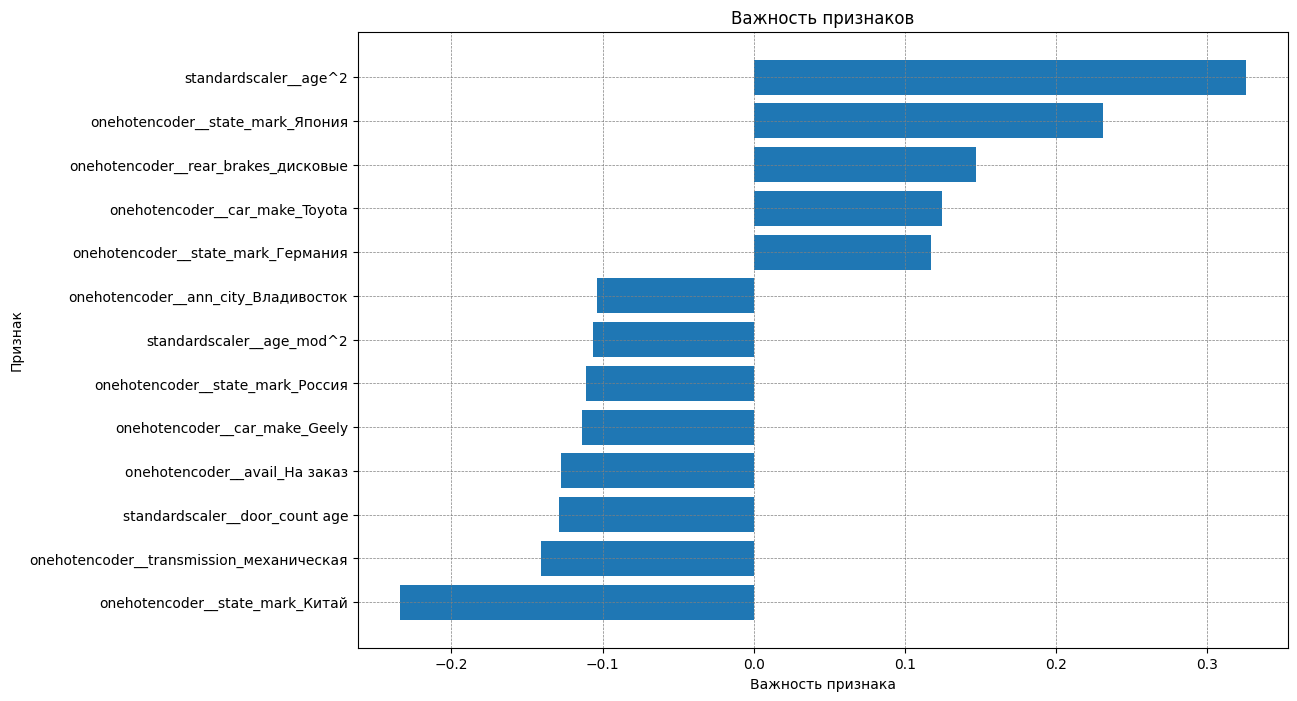

In [56]:
# Проверим важность признаков с точки зрения модели
importances = lr_pl_poly_log.named_steps['linearregression'].coef_
importances = pd.Series(
    importances,
    index = lr_pl_poly_log[:-1].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.1]
# Построим диаграмму для наглядности
plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Линейная регрессия (Lasso)

In [57]:
# Пайплайн обработки данных и обучения модели Lasso
lasso_pl_poly_log = make_pipeline(col_transformer, Lasso())

param_grid_lasso = {
    'lasso__alpha': np.linspace(0.1, 10, 20)
}
gs_lasso_pl_poly_log = GridSearchCV(
                           lasso_pl_poly_log,
                           param_grid=param_grid_lasso,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=4
)

gs_lasso_pl_poly_log.fit(X_train_poly, y_train_log)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_lasso_pl_poly_log.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_lasso_pl_poly_log.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_lasso_pl_poly_log.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_lasso_pl_poly_log.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_lasso_pl_poly_log.best_estimator_,
                    'gs_lasso_pl_poly_log.pkl',
                    compress=0)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
best_score: 0.8348585963249207
best_params: {'lasso__alpha': np.float64(0.1)}


In [58]:
# Вычислим метрики
print_metrics(model=gs_lasso_pl_poly_log.best_estimator_,
              y_train=y_train_log,
              y_test=y_test_log,
              X_train=X_train_poly,
              X_test=X_test_poly)

Обучающая выборка
R2                                        0.83494
MSE                                       0.22482
MAE                                       0.35191
Доля предсказаний 0,95-1,1 от цены        0.90656
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2                                        0.83402


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       0.22587


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE                                       0.35388
Доля предсказаний 0,95-1,1 от цены        0.90775


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### ElasticNet

In [59]:
# Пайплайн обработки данных и обучения модели ElasticNet
elnet_pl_poly_log = make_pipeline(col_transformer, ElasticNet())

param_grid_elnet_log = {
    'elasticnet__alpha': np.linspace(0.1, 10, 20),
    'elasticnet__l1_ratio': np.linspace(0.1, 1, 10),
}
gs_elnet_pl_poly_log = GridSearchCV(
                           elnet_pl_poly_log,
                           param_grid=param_grid_elnet,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=4
)

gs_elnet_pl_poly_log.fit(X_train_poly, y_train_log)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_elnet_pl_poly_log.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_elnet_pl_poly_log.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_elnet_pl_poly_log.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_elnet_pl_poly_log.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_elnet_pl_poly_log.best_estimator_,
                    'gs_elnet_pl_poly_log.pkl',
                    compress=0)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
best_score: 0.8956638425588608
best_params: {'elasticnet__alpha': np.float64(0.1), 'elasticnet__l1_ratio': np.float64(0.1)}


In [60]:
# Вычислим метрики
print_metrics(model=gs_elnet_pl_poly_log.best_estimator_,
              y_train=y_train_log,
              y_test=y_test_log,
              X_train=X_train_poly,
              X_test=X_test_poly)

Обучающая выборка
R2                                        0.89582
MSE                                       0.1419
MAE                                       0.27372
Доля предсказаний 0,95-1,1 от цены        0.91878
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2                                        0.89512


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       0.14272


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE                                       0.27507


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Доля предсказаний 0,95-1,1 от цены        0.92101


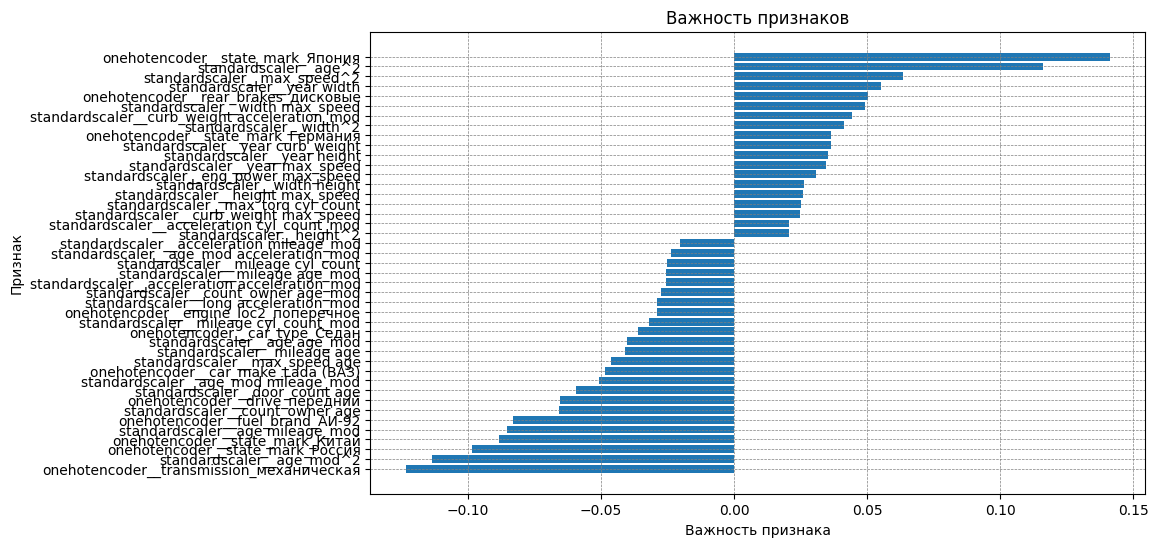

In [61]:
# Проверим важность признаков с точки зрения модели
importances = gs_elnet_pl_poly_log.best_estimator_['elasticnet'].coef_
importances = pd.Series(
    importances,
    index=gs_elnet_pl_poly_log.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.02]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

### Ridge

In [62]:
# Пайплайн обработки данных и обучения линейной модели
ridge_pl_poly_log = make_pipeline(col_transformer, Ridge())

param_grid_ridge = {
    'ridge__alpha': np.linspace(0.1, 10, 20)
}
gs_ridge_pl_poly_log = GridSearchCV(
                           ridge_pl_poly_log,
                           param_grid=param_grid_ridge,
                           scoring='r2',
                           cv=4,
                           n_jobs=-1,
                           verbose=3,
                           error_score='raise',
                           pre_dispatch=3
)

gs_ridge_pl_poly_log.fit(X_train_poly, y_train_log)

# лучшее значение R2 на кросс-валидации
print(f'best_score: {gs_ridge_pl_poly_log.best_score_}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_pl_poly_log.best_params_}')
# Сохраним модель
try:
    _ = joblib.dump(gs_ridge_pl_poly_log.best_estimator_,
                    os.path.join(MODEL_PATH, 'gs_ridge_pl_poly_log.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(gs_ridge_pl_poly_log.best_estimator_,
                    'gs_ridge_pl_poly_log.pkl',
                    compress=0)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
best_score: 0.9420924633741379
best_params: {'ridge__alpha': np.float64(3.2263157894736847)}


In [63]:
# Вычислим метрики
print_metrics(model=gs_ridge_pl_poly_log.best_estimator_,
              y_train=y_train_log,
              y_test=y_test_log,
              X_train=X_train_poly,
              X_test=X_test_poly)

Обучающая выборка
R2                                        0.94439
MSE                                       0.075749
MAE                                       0.18466
Доля предсказаний 0,95-1,1 от цены        0.95118
Тестовая выборка


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2                                        0.94259


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE                                       0.078128


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE                                       0.1875


D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Доля предсказаний 0,95-1,1 от цены        0.94979


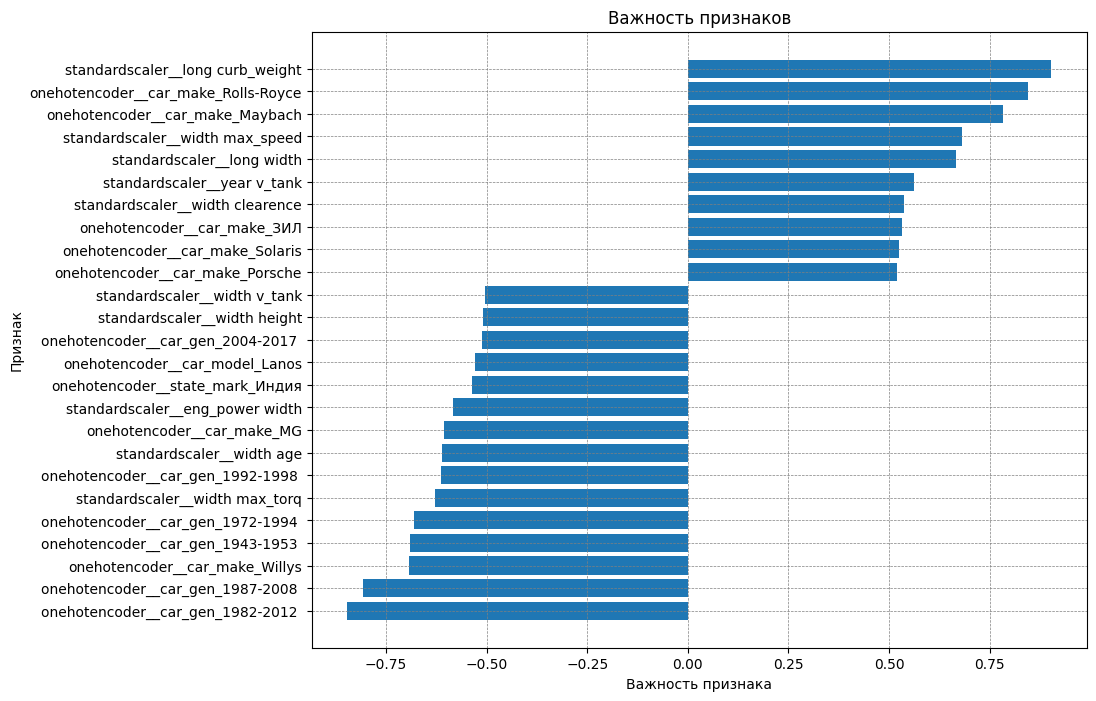

In [64]:
# Проверим важность признаков с точки зрения модели
importances = gs_ridge_pl_poly_log.best_estimator_['ridge'].coef_
importances = pd.Series(
    importances,
    index=gs_ridge_pl_poly_log.best_estimator_['columntransformer'].get_feature_names_out()
).sort_values()
importances = importances[abs(importances)>0.5]
# Построим диаграмму для наглядности
plt.figure(figsize=(10, 8))
plt.title('Важность признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.barh(y=importances.index, width=importances)
plt.show()

Лучший результат среди рассмотренных линейных моделей показала регрессия на всех признаках.